In [1]:
#!/usr/bin/env python3
import os
import json
import h5py
import argparse
import pandas as pd
import numpy as np
import tinydb as db
from tinydb.storages import MemoryStorage
import matplotlib as mpl
import matplotlib.pyplot as plt
# plt.style.use('../clint.mpl')
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

import boost_histogram as bh
import pickle as pl

import scipy

from pygama import DataGroup
import pygama.lh5 as lh5
import pygama.analysis.histograms as pgh
import pygama.analysis.peak_fitting as pgf
import cage_utils
plt.style.use('./joule_dissertation.mplstyle')

Find the start time of superpulses, get the risetimes of the superpulses, compare the risetimes of superpulses at different radii

In [2]:
def asymTrapFilter(wf_in, rise, flat, fall):
    """ Computes an asymmetric trapezoidal filter"""
    wf_out = np.zeros(len(wf_in))
    wf_out[0] = wf_in[0]/float(rise)
    for i in range(1, rise):
        wf_out[i] = wf_out[i-1] + (wf_in[i])/float(rise)
    for i in range(rise, rise+flat):
        wf_out[i] = wf_out[i-1] + (wf_in[i] - wf_in[i-rise])/float(rise)
    for i in range(rise+flat, rise+flat+fall):
        wf_out[i] = wf_out[i-1] + (wf_in[i] - wf_in[i-rise])/float(rise) - wf_in[i-rise-flat]/float(fall)
    for i in range(rise+flat+fall, len(wf_in)):
        wf_out[i] = wf_out[i-1] + (wf_in[i] - wf_in[i-rise])/float(rise) - (wf_in[i-rise-flat] - wf_in[i-rise-flat-fall])/float(fall)
        
    return(wf_out)

In [3]:
def time_point_thresh(wf_in, threshold, tp_max):
    """
    Find the last timepoint before tp_max that wf_in crosses a threshold
     wf_in: input waveform
     threshold: threshold to search for
     tp_out: final time that waveform is less than threshold
    """
    tp_out = 0
    for i in range(tp_max, 0, -1):
        if(wf_in[i]>threshold and wf_in[i-1]<threshold):
            tp_out = i
    return tp_out

In [4]:
def time_point_thresh_max(wf_in, threshold, tp_max, max):
    """
    Find the last timepoint before tp_max that wf_in crosses a threshold
     wf_in: input waveform
     threshold: threshold to search for
     tp_out: final time that waveform is less than threshold
    """
    tp_out = 0
    for i in range(tp_max, max, -1):
        if(wf_in[i]>threshold and wf_in[i-1]<threshold):
            tp_out = i
            
    return tp_out

In [5]:
def time_point_frac(wf_in, frac, tp_max):
    """
    Find the time where the waveform crosses a value that is a fraction of the
    max. Parameters are:
     wf_in: input waveform. Should have baseline of 0!
     frac: fraction of maximum to search for. Should be between 0 and 1.
     tp_max: timepoint of wf maximum. Can be found with numpy.argmax
     tp_out: time that waveform crosses frac * wf_in[tp_max] for the last time,              rounded to an integer index
    """
    # tp_out = [0]
    threshold = frac*wf_in[tp_max]
    # tp_out[0] = tp_max-1
    tp_out = tp_max-1
    # Scan for the crossing
    while(wf_in[tp_out] > threshold):
        tp_out -= 1
    # if the previous point is closer to the threshold than the one we landed on
    # use that. This is equivalent to interpolating and then rounding
    if(threshold - wf_in[tp_out] > wf_in[tp_out+1] - threshold):
        tp_out += 1
    return tp_out

In [6]:
def trap_norm(wf_in, rise, flat):
    """
    Symmetric trapezoidal filter normalized by integration time
    """
    wf_out = np.zeros(len(wf_in))
    wf_out[0] = wf_in[0]/float(rise)
    for i in range(1, rise):
        wf_out[i] = wf_out[i-1] + wf_in[i]/float(rise)
    for i in range(rise, rise+flat):
        wf_out[i] = wf_out[i-1] + (wf_in[i] - wf_in[i-rise])/float(rise)
    for i in range(rise+flat, 2*rise+flat):
        wf_out[i] = wf_out[i-1] + (wf_in[i] - wf_in[i-rise] - wf_in[i-rise-flat])/float(rise)
    for i in range(2*rise+flat, len(wf_in)):
        wf_out[i] = wf_out[i-1] + (wf_in[i] - wf_in[i-rise] - wf_in[i-rise-flat] + wf_in[i-2*rise-flat])/float(rise)
        
    return wf_out

Load superpulses

In [7]:
f_superpulse = './data/normScan/new_superpulses_60keV_allRuns.hdf5'
data_superpulse = pd.read_hdf(f_superpulse, key = '/superpulses')
# raw_superpulse_60 = data_superpulse['pure_60'][0]
# raw_superpulse_60_notched = cage_utils.notchFilter_SIS3302(raw_superpulse_60, Q=20)

In [8]:
# wf_arr = np.array(data_superpulse['pure_60_pz'])
wf_arr = np.array(data_superpulse['pure_60_raw_pz'])

# wf_arr = []
# for wf in data_superpulse['pure_60_pz']:
#     wf_arr.append(wf)

Calculate a t0 using time_point_thresh

In [50]:
traps_0 = []
Etraps = []
tp_0 = []
E_ftp = []
wfs_blsub = []
for n in range(len(wf_arr)):
    Etrap= trap_norm(wf_arr[n], 100, 400)
    
    trap_0 = asymTrapFilter(wf_arr[n], 100, 1, 400) #100, 1, 400 #20, 100, 400
    max_trap_0 = np.argmax(trap_0)
#     t0 = time_point_thresh(trap_0, 0.00, max_trap_0)
    t0 = time_point_thresh_max(trap_0, 0.00, max_trap_0, max_trap_0 - 200)
    
    Eftp = Etrap[t0 + 400]
    
    traps_0.append(trap_0)
    Etraps.append(Etrap)
    tp_0.append(t0)
    E_ftp.append(Eftp)
    print(f't0: {t0} \nE_ftp: {Eftp}')
    

t0: 3774 
E_ftp: 161.0515698604385
t0: 3786 
E_ftp: 161.05828366649382
t0: 3783 
E_ftp: 161.00943378754025
t0: 3758 
E_ftp: 160.19741036274468
t0: 3730 
E_ftp: 158.4636781719449


In [ ]:
print(len(wf_arr))

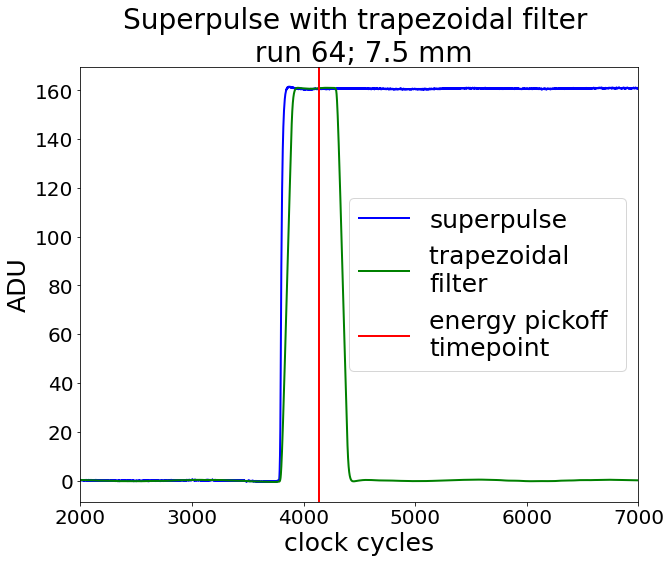

In [15]:
# plt.plot(wfs_blsub[1][:-1], c = 'b')
plt.plot(wf_arr[1][:-1], lw=2, c = 'b', label = 'superpulse')
plt.plot(Etraps[1][:-1], lw=2, c = 'g', label= 'trapezoidal \nfilter')
# plt.plot(traps_0[3][:-1], lw=2, c = 'r')
# plt.axvline(tp_0[3], lw=2, c='r')
plt.axvline(tp_0[3]+400, lw=2, c='r', label='energy pickoff \ntimepoint')
# plt.axhline(0., lw=2, c='r')

# plt.ylim(-1., 2)
# plt.xlim(3700, 3850)
plt.xlim(2000,7000)
# plt.xlim(3950, 3970)
# plt.ylim(150, 170)

plt.xlabel('clock cycles')
plt.ylabel('ADU')
plt.title('Superpulse with trapezoidal filter \n run 64; 7.5 mm')
plt.legend()
# plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/superpulse_trapEftp.png', dpi=200)
# plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/superpulse_trapEftp.pdf', dpi=200)

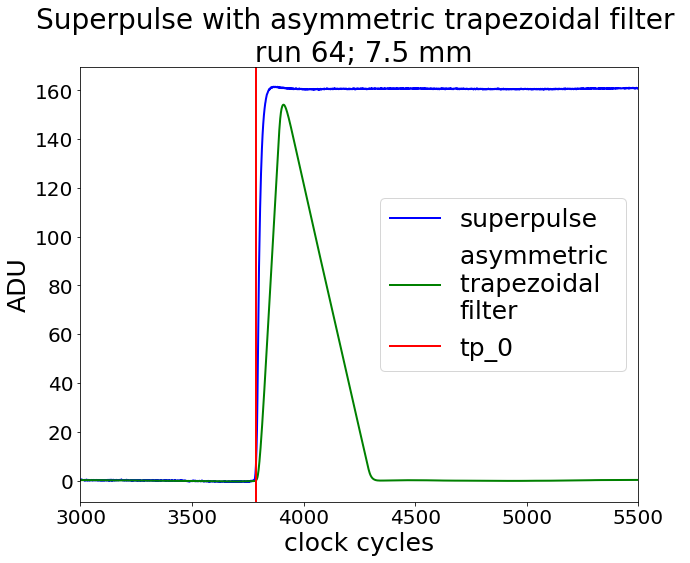

In [51]:
# plt.plot(wfs_blsub[1][:-1], c = 'b')
plt.plot(wf_arr[1][:-1], lw=2, c = 'b', label = 'superpulse')
# plt.plot(Etraps[1][:-1], lw=2, c = 'g', label= 'trapezoidal \nfilter')
plt.plot(traps_0[1][:-1], lw=2, c = 'g', label='asymmetric \ntrapezoidal \nfilter')
plt.axvline(tp_0[1], lw=2, c='r', label='tp_0')
# plt.axvline(tp_0[1]+400, lw=2, c='r', label='energy pickoff \ntimepoint')
# plt.axhline(0., lw=2, c='r')

# plt.ylim(-1., 2)
# plt.xlim(3720, 3850)
# plt.ylim(-1, 20)
plt.xlim(3000,5500)
# plt.xlim(3950, 3970)
# plt.ylim(150, 170)

plt.xlabel('clock cycles')
plt.ylabel('ADU')
plt.title('Superpulse with asymmetric trapezoidal filter \n run 64; 7.5 mm')
plt.legend()
# plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/superpulse_t0_full_run64.png', dpi=200)
# plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/superpulse_t0_full_run64.pdf', dpi=200)
# plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/superpulse_t0_full_run64.png', dpi=200)
# plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/superpulse_t0_full_run64.pdf', dpi=200)

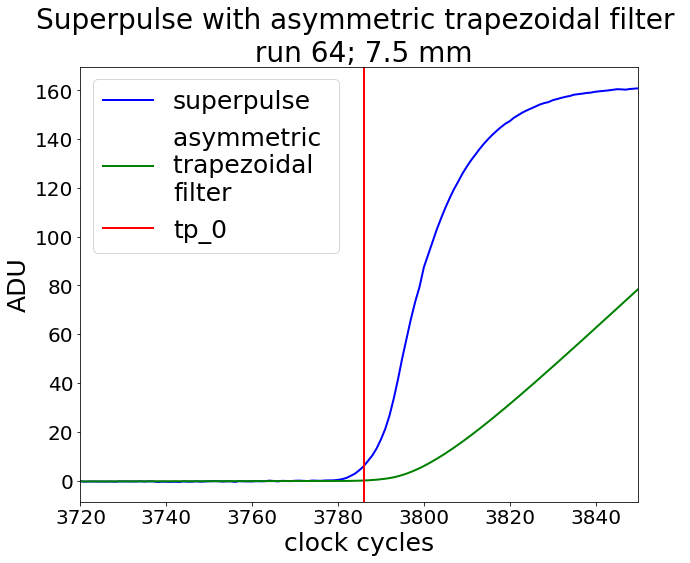

In [52]:
# plt.plot(wfs_blsub[1][:-1], c = 'b')
plt.plot(wf_arr[1][:-1], lw=2, c = 'b', label = 'superpulse')
# plt.plot(Etraps[1][:-1], lw=2, c = 'g', label= 'trapezoidal \nfilter')
plt.plot(traps_0[1][:-1], lw=2, c = 'g', label='asymmetric \ntrapezoidal \nfilter')
plt.axvline(tp_0[1], lw=2, c='r', label='tp_0')
# plt.axvline(tp_0[1]+400, lw=2, c='r', label='energy pickoff \ntimepoint')
# plt.axhline(0., lw=2, c='r')

# plt.ylim(-1., 2)
plt.xlim(3720, 3850)
# plt.ylim(-1, 20)
# plt.xlim(3000,5500)
# plt.xlim(3950, 3970)
# plt.ylim(150, 170)

plt.xlabel('clock cycles')
plt.ylabel('ADU')
plt.title('Superpulse with asymmetric trapezoidal filter \n run 64; 7.5 mm')
plt.legend()
# plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/superpulse_t0_rise_run64.png', dpi=200)
# plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/superpulse_t0_rise_run64.pdf', dpi=200)

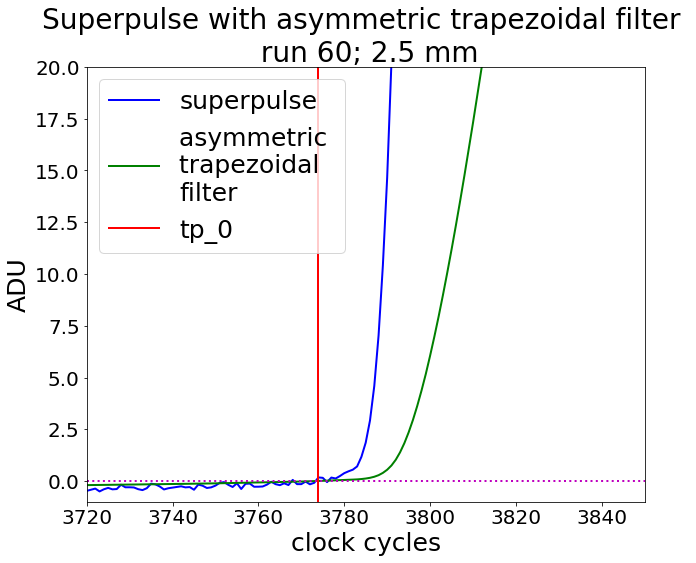

In [53]:
# plt.plot(wfs_blsub[1][:-1], c = 'b')
plt.plot(wf_arr[0][:-1], lw=2, c = 'b', label = 'superpulse')
# plt.plot(Etraps[1][:-1], lw=2, c = 'g', label= 'trapezoidal \nfilter')
plt.plot(traps_0[0][:-1], lw=2, c = 'g', label='asymmetric \ntrapezoidal \nfilter')
plt.axvline(tp_0[0], lw=2, c='r', label='tp_0')
# plt.axvline(tp_0[1]+400, lw=2, c='r', label='energy pickoff \ntimepoint')
# plt.axhline(0., lw=2, c='r')

# plt.ylim(-1., 2)
plt.xlim(3720, 3850)
plt.ylim(-1, 20)
# plt.xlim(2000,7000)
# plt.xlim(3950, 3970)
# plt.ylim(150, 170)
plt.axhline(0., linestyle='dotted', c='m', linewidth=2.)

plt.xlabel('clock cycles')
plt.ylabel('ADU')
plt.title('Superpulse with asymmetric trapezoidal filter \n run 60; 2.5 mm')
plt.legend()
# plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/superpulse_t0_riseZoom_run60.png', dpi=200)
# plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/superpulse_t0_riseZoom_run60.pdf', dpi=200)

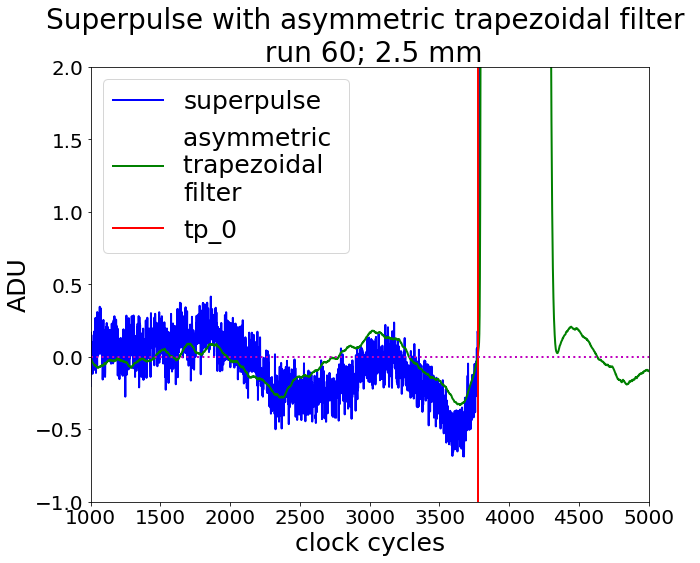

In [54]:
# plt.plot(wfs_blsub[1][:-1], c = 'b')
plt.plot(wf_arr[0][:-1], lw=2, c = 'b', label = 'superpulse')
# plt.plot(Etraps[1][:-1], lw=2, c = 'g', label= 'trapezoidal \nfilter')
plt.plot(traps_0[0][:-1], lw=2, c = 'g', label='asymmetric \ntrapezoidal \nfilter')
plt.axvline(tp_0[0], lw=2, c='r', label='tp_0')
# plt.axvline(tp_0[1]+400, lw=2, c='r', label='energy pickoff \ntimepoint')
# plt.axhline(0., lw=2, c='r')

# plt.ylim(-1., 2)
plt.xlim(1000, 5000)
plt.ylim(-1, 2.)
# plt.xlim(2000,7000)
# plt.xlim(3950, 3970)
# plt.ylim(150, 170)
plt.axhline(0., linestyle='dotted', c='m', linewidth=2.)

plt.xlabel('clock cycles')
plt.ylabel('ADU')
plt.title('Superpulse with asymmetric trapezoidal filter \n run 60; 2.5 mm')
plt.legend()
# plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/superpulse_t0_blZoom_run60.png', dpi=200)
# plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/superpulse_t0_blZoom_run60.pdf', dpi=200)

Now I'm just comparing normalizing before vs after PZ correcting

In [ ]:
wf_norm_arr = np.zeros((len(wf_arr), len(wf_arr[0])))

for n in range(len(wf_arr)):
    wf_norm_arr[n] = np.divide(wf_arr[n], E_ftp[n])

In [ ]:
# plt.plot(wfs_blsub[1][:-1], c = 'b')

for n in range(len(wf_norm_arr)):
    
    plt.plot(wf_norm_arr[n][:-1])
plt.axhline(1., c='r')


# plt.ylim(-0.5, 25)
# plt.xlim(3930, 4000)
plt.xlim(3930, 3960)
# plt.ylim(150, 170)
plt.ylim(0.9, 1.01)

In [ ]:
wf_pz_corr_arr = np.array(data_superpulse['pure_60'])

# wf_pz_corr_arr = []
# for wf in data_superpulse['pure_60']:
#     wf_pz_corr_arr.append(wf)
    
wf_pz_arr_raw = cage_utils.double_pole_zero(wf_pz_corr_arr, 21250, 433, 0.045)

wf_pz_arr = np.array(wf_pz_arr_raw)*(1/(1 - 0.045))

bkg_wf_pz_raw = cage_utils.double_pole_zero([data_superpulse['bkg'][0]], 21250, 433, 0.045)[0]

print(len(bkg_wf_pz_raw ))
bkg_wf_pz = np.array(bkg_wf_pz_raw)*(1/(1-0.045))

In [ ]:
bkg_wf = data_superpulse['bkg_pz'][0]
# bkg_wf_norm = np.divide(bkg_wf, np.amax(bkg_wf))
# bkg_notched = cage_utils.notchFilter_SIS3302(bkg_wf, Q=20)

In [ ]:
rad_arr = np.array(data_superpulse['radius'])
times = np.array(data_superpulse['samples'][0])
# print(len(times))

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.plasma(np.linspace(0, 1, len(wf_arr)+1))
c = np.arange(0, len(wf_arr)+1)
# norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.tab10)
cmap.set_array([])

# cmap = mpl.cm.viridis
# bounds = rad_arr
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

for n in range(len(wf_arr)):
    ax.plot(times[:-100], wf_arr[n][:-100], c=cmap.to_rgba(n), label = f'{rad_arr[n]} mm')

ax.plot(times[:-100], bkg_wf[:-100], c=cmap.to_rgba(5), label = f'Bkg')
cb = fig.colorbar(cmap, spacing='proportional', ticks=range(len(rad_arr)+1), boundaries=np.arange(-0.5, len(rad_arr)+1.5))

# cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
#              cax=ax,ticks=rad_arr, spacing='proportional' )
labels = np.append(rad_arr, 'Background')
cb.ax.set_yticklabels(labels)
cb.set_label("Radius (mm)", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)
# cb.ax.set_ylim(-0.5, len(rad_arr) - 0.5)

# ax.text(0.95, 0.83, f'{wf_cut}', verticalalignment='top',
#                         horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
#                         bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'60 keV superpulses (PZ-corrected) \nnormal incidence', fontsize=16)



plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.xlabel('clock cycles', fontsize=20)
plt.ylabel('normalized ADU', fontsize = 20)

# plt.axhline(y=1, c = 'r')

# plt.xlim(0, 4300)
# plt.ylim(-0.025, 0.1)

# plt.xlim(3900, 4100)
# plt.ylim(-0.015, 0.2)

# plt.xlim(3700, 3710)
# plt.ylim(-0.025, 0.1)


plt.xlim(3800, 8000)
# plt.ylim(0.75, 1.005)
plt.ylim(0.75, 1.01)

# plt.xlim(3800, 4300)
# plt.ylim(0.95, 1.01)

# plt.xlim(3900, 3980)
# plt.ylim(-0.015, 0.5)

# plt.xlim(4500, 6000)
# plt.ylim(0.85, 0.95)
# plt.xlim(8000, 8190)



# plt.legend()

plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes()

# set up colorbar to plot waveforms of different radii
c = np.arange(0, len(wf_arr)+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.tab10)
cmap.set_array([])

for n in range(len(wf_arr)):
    ax.plot(times[:-100], wf_arr[n][:-100], c=cmap.to_rgba(n), label = f'{rad_arr[n]} mm')

ax.plot(times[:-100], bkg_wf[:-100], c=cmap.to_rgba(5), label = f'Bkg')
cb = fig.colorbar(cmap, spacing='proportional', ticks=range(len(rad_arr)+1), boundaries=np.arange(-0.5, len(rad_arr)+1.5))

labels = np.append(rad_arr, 'Background')
cb.ax.set_yticklabels(labels)
cb.set_label("Radius (mm)", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

plt.title(f'60 keV superpulses (PZ-corrected) \nnormal incidence', fontsize=20)

plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.xlabel('clock cycles', fontsize=20)
plt.ylabel('normalized ADU', fontsize=20)


# ____________________________________________
# inset for risetime of WF
axins = ax.inset_axes([200, 0.4, 3500,  0.6], transform=ax.transData) # [x_start, y_start, x_length, y_length]


# sub region of the original image
x1, x2, y1, y2 = 3920, 3980, -0.015, 0.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

for n in range(len(wf_arr)):
    axins.plot(times[:-100], wf_arr[n][:-100], c=cmap.to_rgba(n), label = f'{rad_arr[n]} mm')
axins.plot(times[:-100], bkg_wf[:-100], c=cmap.to_rgba(5), label = f'Bkg')

ax.indicate_inset_zoom(axins, edgecolor="black")

# ____________________________________________
# inset for top of WF
axins2 = ax.inset_axes([5000, 0.1, 3000,  0.6], transform=ax.transData) # [x_start, y_start, x_length, y_length]


# sub region of the original image
x11, x22, y11, y22 = 3950, 4500, 0.9, 1.005
axins2.set_xlim(x11, x22)
axins2.set_ylim(y11, y22)

for n in range(len(wf_arr)):
    axins2.plot(times[:-100], wf_arr[n][:-100], c=cmap.to_rgba(n), label = f'{rad_arr[n]} mm')
axins2.plot(times[:-100], bkg_wf[:-100], c=cmap.to_rgba(5), label = f'Bkg')

ax.indicate_inset_zoom(axins2, edgecolor="black")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.plasma(np.linspace(0, 1, len(wf_arr)+1))
c = np.arange(0, len(wf_arr)+1)
# norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.tab10)
cmap.set_array([])

# cmap = mpl.cm.viridis
# bounds = rad_arr
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

for n in range(len(wf_arr)):
    plt.plot(times[:-100], wf_arr[n][:-100], c=cmap.to_rgba(n), label = f'{rad_arr[n]} mm')

plt.plot(times[:-100], bkg_wf[:-100], c=cmap.to_rgba(5), label = f'Bkg')
cb = fig.colorbar(cmap, spacing='proportional', ticks=range(len(rad_arr)+1), boundaries=np.arange(-0.5, len(rad_arr)+1.5))

# cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
#              cax=ax,ticks=rad_arr, spacing='proportional' )
labels = np.append(rad_arr, 'Background')
cb.ax.set_yticklabels(labels)
cb.set_label("Radius (mm)", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)
# cb.ax.set_ylim(-0.5, len(rad_arr) - 0.5)

# ax.text(0.95, 0.83, f'{wf_cut}', verticalalignment='top',
#                         horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
#                         bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'60 keV superpulses \nPZ before norm', fontsize=16)



plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.xlabel('clock cycles', fontsize=20)

plt.axhline(y=1, c = 'r')

# plt.xlim(0, 4300)
# plt.ylim(-0.025, 0.1)

# plt.xlim(3900, 4000)
# plt.ylim(-0.015, 0.2)

# plt.xlim(3700, 3710)
# plt.ylim(-0.025, 0.1)


plt.xlim(3800, 8000)
# plt.ylim(0.75, 1.005)
plt.ylim(0.95, 1.01)

# plt.xlim(3800, 4300)
# plt.ylim(0.95, 1)

# plt.xlim(3900, 4025)
# plt.ylim(-0.015, 0.3)

# plt.xlim(4500, 6000)
# plt.ylim(0.85, 0.95)
# plt.xlim(8000, 8190)


plt.legend()




In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.plasma(np.linspace(0, 1, len(wf_pz_arr)+1))
c = np.arange(0, len(wf_pz_arr)+1)
# norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.tab10)
cmap.set_array([])

# cmap = mpl.cm.viridis
# bounds = rad_arr
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

for n in range(len(wf_pz_arr)):
    plt.plot(times[:-100], wf_pz_arr[n][:-100], c=cmap.to_rgba(n), label = f'{rad_arr[n]} mm')

plt.plot(times[:-100], bkg_wf_pz[:-100], c=cmap.to_rgba(5), label = f'Bkg')
cb = fig.colorbar(cmap, spacing='proportional', ticks=range(len(rad_arr)+1), boundaries=np.arange(-0.5, len(rad_arr)+1.5))

# cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
#              cax=ax,ticks=rad_arr, spacing='proportional' )
labels = np.append(rad_arr, 'Background')
cb.ax.set_yticklabels(labels)
cb.set_label("Radius (mm)", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)
# cb.ax.set_ylim(-0.5, len(rad_arr) - 0.5)

# ax.text(0.95, 0.83, f'{wf_cut}', verticalalignment='top',
#                         horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
#                         bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'60 keV superpulses \nPZ-after norm, corr by *1/(1-frac)', fontsize=16)



plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.xlabel('clock cycles', fontsize=20)

plt.axhline(y=1, c = 'r')


# plt.xlim(0, 4300)
# plt.ylim(-0.025, 0.1)

# plt.xlim(3900, 4000)
# plt.ylim(-0.015, 0.2)

# plt.xlim(3700, 3710)
# plt.ylim(-0.025, 0.1)


# plt.xlim(3800, 8000)
# plt.ylim(0.75, 1)

plt.xlim(3800, 8000)
# plt.ylim(0.75, 1.005)
plt.ylim(0.95, 1.015)

# plt.xlim(3800, 4300)
# plt.ylim(0.95, 1)

# plt.xlim(3900, 4025)
# plt.ylim(-0.015, 0.3)

# plt.xlim(4500, 6000)
# plt.ylim(0.85, 0.95)
# plt.xlim(8000, 8190)


plt.legend()


In [ ]:
sub = wf_arr - wf_pz_arr
print(sub)

bkg_sub = bkg_wf - bkg_wf_pz

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.plasma(np.linspace(0, 1, len(sub)+1))
c = np.arange(0, len(sub)+1)
# norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.tab10)
cmap.set_array([])

# cmap = mpl.cm.viridis
# bounds = rad_arr
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

for n in range(len(sub)):
    plt.plot(times[:-100], sub[n][:-100], c=cmap.to_rgba(n), label = f'{rad_arr[n]} mm')

plt.plot(times[:-100], bkg_sub[:-100], c=cmap.to_rgba(5), label = f'Bkg')
cb = fig.colorbar(cmap, spacing='proportional', ticks=range(len(rad_arr)+1), boundaries=np.arange(-0.5, len(rad_arr)+1.5))

# cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
#              cax=ax,ticks=rad_arr, spacing='proportional' )
labels = np.append(rad_arr, 'Background')
cb.ax.set_yticklabels(labels)
cb.set_label("Radius (mm)", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)
# cb.ax.set_ylim(-0.5, len(rad_arr) - 0.5)

# ax.text(0.95, 0.83, f'{wf_cut}', verticalalignment='top',
#                         horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
#                         bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'difference', fontsize=16)



plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.xlabel('clock cycles', fontsize=20)

# plt.xlim(0, 4300)
# plt.ylim(-0.025, 0.1)

# plt.xlim(3900, 4000)
# plt.ylim(-0.015, 0.2)

# plt.xlim(3700, 3710)
# plt.ylim(-0.025, 0.1)


# plt.xlim(3800, 8000)
# plt.ylim(0.75, 1)

# plt.xlim(3800, 4300)
# plt.ylim(0.95, 1)

# plt.xlim(3900, 4025)
# plt.ylim(-0.015, 0.3)

# plt.xlim(4500, 6000)
# plt.ylim(0.85, 0.95)
# plt.xlim(8000, 8190)


plt.legend()

In [ ]:
arg_maxes = np.array(data_superpulse['argmax_pure_60'])
print(arg_maxes)

In [ ]:
run_list = [60, 50, 45, 10]
tp_list = ['hi', 'bye', 'three']

for tp, n in zip(tp_list, range(len(tp_list))):
    print(tp, n)

In [ ]:
print(tp_0)

In [ ]:
test = np.zeros(shape = (5, 10))
print(test)
test2 = np.zeros(10)
print(test2)

In [ ]:
tp_0max = np.array(tp_max) - np.array(tp_0)
plt.plot(tp_0max[:-1], '.b')

In [ ]:
def trap_norm(wf_in, rise, flat):
    """
    Symmetric trapezoidal filter normalized by integration time
    """
    wf_out = np.zeros(len(wf_in))
    wf_out[0] = wf_in[0]/float(rise)
    for i in range(1, rise):
        wf_out[i] = wf_out[i-1] + wf_in[i]/float(rise)
    for i in range(rise, rise+flat):
        wf_out[i] = wf_out[i-1] + (wf_in[i] - wf_in[i-rise])/float(rise)
    for i in range(rise+flat, 2*rise+flat):
        wf_out[i] = wf_out[i-1] + (wf_in[i] - wf_in[i-rise] - wf_in[i-rise-flat])/float(rise)
    for i in range(2*rise+flat, len(wf_in)):
        wf_out[i] = wf_out[i-1] + (wf_in[i] - wf_in[i-rise] - wf_in[i-rise-flat] + wf_in[i-2*rise-flat])/float(rise)
        
    return wf_out

Take a first look at risetime plots. Done properly in ./analysis_60keV.py

In [ ]:
rt_0590 = []
rt_0550 = []
rt_1090 = []
rt_1050 = []
rt_5090 = []

for n in range(len(wf_arr)):
    t_05 = time_point_frac(wf_arr[n], 0.05, arg_maxes[n])
    t_10 = time_point_frac(wf_arr[n], 0.1, arg_maxes[n])
    t_90 = time_point_frac(wf_arr[n], 0.9, arg_maxes[n])
    t_50 = time_point_frac(wf_arr[n], 0.5, arg_maxes[n])
    rt_0590.append(t_90-t_05)
    rt_0550.append(t_50-t_05)
    rt_1090.append(t_90-t_10)
    rt_1050.append(t_50-t_10)
    rt_5090.append(t_90-t_50)

In [ ]:

plt.plot(rad_arr, rt_0590, 'or')
plt.plot(rad_arr, rt_1090, 'Xb')
plt.plot(rad_arr, rt_1050, 'Pg')
plt.plot(rad_arr, rt_5090, 'Xc')
plt.plot(rad_arr, rt_0550, '^m')

In [ ]:
trap_rt_0590 = []
trap_rt_0550 = []
trap_rt_1090 = []
trap_rt_1050 = []
trap_rt_5090 = []
trap_rt_1025 = []
trap_rt_0525 = []

for n in range(len(wf_arr)):
    t_05 = time_point_frac(wf_arr[n], 0.05, tp_max[n])
    t_10 = time_point_frac(wf_arr[n], 0.1, tp_max[n])
    t_25 = time_point_frac(wf_arr[n], 0.25, tp_max[n])
    t_90 = time_point_frac(wf_arr[n], 0.9, tp_max[n])
    t_50 = time_point_frac(wf_arr[n], 0.5, tp_max[n])
    trap_rt_0590.append(t_90-t_05)
    trap_rt_1090.append(t_90-t_10)
    trap_rt_0550.append(t_50-t_05)
    trap_rt_1050.append(t_50-t_10)
    trap_rt_5090.append(t_90-t_50)
    trap_rt_1025.append(t_25 - t_10)
    trap_rt_0525.append(t_25 - t_05)

In [ ]:
plt.plot(rad_arr, trap_rt_0590, 'or', label = '05 - 90')
plt.plot(rad_arr, trap_rt_1090, 'Xb', label = '10 - 90')
plt.plot(rad_arr, trap_rt_1050, 'Pg', label = '10 - 50')
plt.plot(rad_arr, trap_rt_5090, 'vc', label = '50 - 90')
plt.plot(rad_arr, trap_rt_0550, '^m', label = '05 - 50')
plt.plot(rad_arr, trap_rt_0525, '^r', label = '05 - 25')
plt.plot(rad_arr, trap_rt_1025, 'om', label = '10 - 25')
plt.legend()

In [ ]:
diff_trap_rt_0590 = np.abs(np.diff(trap_rt_0590))
diff_trap_rt_0550 = np.abs(np.diff(trap_rt_0550))
diff_trap_rt_1090 = np.abs(np.diff(trap_rt_1090))
diff_trap_rt_1050 = np.abs(np.diff(trap_rt_1050))
diff_trap_rt_5090 = np.abs(np.diff(trap_rt_5090))

In [ ]:
plt.plot(diff_trap_rt_0590, 'or')
plt.plot(diff_trap_rt_1090, 'Xb')
plt.plot(diff_trap_rt_1050, 'Pg')
plt.plot(diff_trap_rt_5090, 'vc')
plt.plot(diff_trap_rt_0550, '^m')

In [ ]:
filt = np.linspace(0.0015, 0.010, 20)
t0_arr = []
for n in range(len(wf_arr)):
    tp_0_opt = []
    for m in filt:
        trap_0 = asymTrapFilter(wf_arr[n], 2, 100, 400)
        t0 = time_point_thresh(trap_0, m, max_trap_0)
        tp_0_opt.append(t0)
        # print(f'{m}: t0 = {t0}')
    t0_arr.append(tp_0_opt)

In [ ]:
print(t0_arr)

In [ ]:
for n in range(len(wf_arr)):
    plt.plot(filt, t0_arr[n], 'o', label = f'{rad_arr[n]} mm',)
    
plt.ylim(3940, 3960)
plt.legend()

In [ ]:
print(traps_max)

In [ ]:
tp_0_new = []
rt_0_100 = []
traps_0 = []
for n in range(len(wf_arr)):
    trap_0 = asymTrapFilter(wf_arr[n],  2, 100, 400)
    max_trap_0 = np.argmax(trap_0)
    t0 = time_point_thresh(trap_0, 0.003, max_trap_0)
    tp_0_new.append(t0)
    traps_0.append(trap_0)
    rt = (tp_max[n] - t0)*10
    rt_0_100.append(rt)
    print(rt)
#     print(f't0: {t0}n')
    

In [ ]:
print(rad_arr)

In [ ]:
plt.plot(rad_arr, rt_0_100, 'o')
# plt.yim

In [ ]:
plt.plot(wf_arr[2])
# plt.plot(traps_max[2], '-r')
# plt.axvline(tp_max[2], c = 'r')
# plt.axvline(maxes[1], c = 'c')
plt.plot(traps_0[2], '-c')
plt.axvline(tp_0_new[2], c = 'c')

plt.xlim(3900, 4200)
# plt.ylim(-0.005, 0.025)

In [ ]:
trap_super60 = asymTrapFilter(superpulse_60, 2, 100, 400)
max_trap_60 = np.argmax(trap_super60)
tp_0_60 = time_point_thresh(trap_super60, 0.002, max_trap_60)
print(tp_0_60)
# print(trap_super60[3955])

In [ ]:
plt.plot(superpulse_60[:-1] )
plt.plot(trap_super60[:-1])
plt.title('physics superpulse')
plt.axvline(tp_0_60)
# plt.xlim(3800, 4200)
# plt.xlim(3950, 3960)
# # plt.xlim(0, 3800)
# plt.ylim(-0.01, 0.2)

In [ ]:
tp_max = np.argmax(superpulse_60)
print(tp_max)

In [ ]:
risetime = tp_max-tp_0_60
print(risetime)

In [ ]:
risetime_ns = risetime*10

In [ ]:
risetimes = []
filt = np.linspace(2, 400, 800)

for f in filt:
    trap_super60 = asymTrapFilter(superpulse_60, 2, 100, int(f))
    max_trap_60 = np.argmax(trap_super60)
    tp_0_60 = time_point_thresh(trap_super60, 0.002, max_trap_60)
#     print(tp_0_60)
    rise = (tp_max - tp_0_60)*10
#     print(f'risetime: {rise} ns')
    risetimes.append(rise)

In [ ]:
plt.plot(filt, risetimes)

In [ ]:
trap_super60 = asymTrapFilter(superpulse_60, 2, 100, 2)
max_trap_60 = np.argmax(trap_super60)
tp_0_60 = time_point_thresh(trap_super60, 0.002, max_trap_60)
print(tp_0_60)

In [ ]:
plt.plot(superpulse_60[:-1] )
plt.plot(trap_super60[:-1])
plt.title('physics superpulse')
plt.axvline(tp_0_60)
plt.axvline(tp_max )
# plt.xlim(3800, 4200)
plt.xlim(3950, 4200)
# # plt.xlim(0, 3800)
# plt.ylim(-0.01, 0.2)

In [ ]:
# tp_max = 
rt = (max_trap_60 - tp_0_60)*10
print(rt)

In [ ]:
max_risetimes = []
max_filt = np.linspace(2, 20, 100)

for f in max_filt:
    max_trap_super60 = asymTrapFilter(superpulse_60, int(f), 100, 400)
    max_trap_60 = np.argmax(max_trap_super60)
#     print(tp_0_60)
    max_rise = (max_trap_60 - tp_0_60)*10
#     print(f'risetime: {rise} ns')
    max_risetimes.append(max_rise)

In [ ]:
plt.plot(max_filt, max_risetimes)

In [ ]:
max_trap_super60 = asymTrapFilter(superpulse_60, 20, 10, 400)
max_trap_60 = np.argmax(max_trap_super60)
print(max_trap_60)
print(tp_max)

In [ ]:
plt.plot(superpulse_60[:-1] )
plt.plot(trap_super60[:-1])
plt.title('physics superpulse')
plt.axvline(tp_0_60)
plt.axvline(max_trap_60)
# plt.xlim(3800, 4200)
plt.xlim(3950, 4200)
# # plt.xlim(0, 3800)
# plt.ylim(-0.01, 0.2)